In [1]:
import torch
import torch.nn as nn
import os
from math import log2
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image, ImageReadMode
import matplotlib.pyplot as plt
from time import time

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, k, s, p):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.block(x)


In [3]:
class TransposeConvBlock(nn.Module):
    def __init__(self, in_c, out_c, k, s, p):
        super().__init__()

        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(0.5),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)


In [4]:
class Generator(nn.Module):
    def __init__(self, img_c):
        super().__init__()

        self.down1 = nn.Sequential(
          nn.Conv2d(img_c, 64, 4, 2, 1), # 256 -> 128
          nn.LeakyReLU()
        )
        self.down2 = ConvBlock(64, 128, 4, 2, 1) # 128 -> 64
        self.down3 = ConvBlock(128, 256, 4, 2, 1) # 64 -> 32
        self.down4 = ConvBlock(256, 512, 4, 2, 1) # 32 -> 16
        self.down5 = ConvBlock(512, 512, 4, 2, 1) # 16 -> 8
        self.down6 = ConvBlock(512, 512, 4, 2, 1) # 8 -> 4
        self.down7 = ConvBlock(512, 512, 4, 2, 1) # 4 -> 2
        self.down8 = ConvBlock(512, 512, 4, 2, 1) # 2 -> 1

        self.up1 = TransposeConvBlock(512, 512, 4, 2, 1) # 1 -> 2
        self.up2 = TransposeConvBlock(1024, 1024, 4, 2, 1) # 2 -> 4
        self.up3 = TransposeConvBlock(1536, 1024, 4, 2, 1) # 4 -> 8
        self.up4 = TransposeConvBlock(1536, 1024, 4, 2, 1) # 8 -> 16
        self.up5 = TransposeConvBlock(1536, 1024, 4, 2, 1) # 16 -> 32
        self.up6 = TransposeConvBlock(1280, 512, 4, 2, 1) # 32 -> 64
        self.up7 = TransposeConvBlock(640, 256, 4, 2, 1) # 64 -> 128
        self.up8 = TransposeConvBlock(320, 128, 4, 2, 1) # 128 -> 256
        self.up9 = nn.Sequential(
            nn.Conv2d(128, 3, 3, 1, 1), # 128C to 3C
            nn.Tanh()
        )

    def forward(self, x):
        # Encode
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat((u1, d7), dim=1))
        u3 = self.up3(torch.cat((u2, d6), dim=1))
        u4 = self.up4(torch.cat((u3, d5), dim=1))
        u5 = self.up5(torch.cat((u4, d4), dim=1))
        u6 = self.up6(torch.cat((u5, d3), dim=1))
        u7 = self.up7(torch.cat((u6, d2), dim=1))
        u8 = self.up8(torch.cat((u7, d1), dim=1))
        u9 = self.up9(u8)

        return u9

In [5]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
          nn.Conv2d(3, 64, 4, 2, 1),
          nn.LeakyReLU(),
          ConvBlock(64, 128, 4, 2, 1),
          ConvBlock(128, 256, 4, 2, 1),
          ConvBlock(256, 512, 4, 2, 1),
          nn.Conv2d(512, 1, 3, 1, 1),
        )

    def forward(self, x):
        return self.net(x)

In [6]:
# Data from https://www.kaggle.com/datasets/arka47/movie-frames-24k
class ColorizationDatasetMovies(Dataset):
    def __init__(self, rootDir=r'data/archive/movie_colored_frames', img_size=256, train=True):
        self.color = f'{rootDir}'
        self.img_size = img_size
        self.len = 0
        for path in os.listdir(self.color):
            if os.path.isfile(os.path.join(self.color, path)): self.len += 1
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        color_path = f'{self.color}/{str(idx).zfill(5)}.jpg'
        image_black = read_image(color_path, mode=ImageReadMode.GRAY) / 255
        image_color = read_image(color_path) / 255

        # Scale between -1 and 1
        image_black = image_black * 2 - 1
        image_color = image_color * 2 - 1

        # Resize and randomly crop
        state = torch.get_rng_state()
        t = transforms.RandomResizedCrop(self.img_size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=transforms.InterpolationMode.BILINEAR)
        image_black = t(image_black)
        torch.set_rng_state(state)
        image_color = t(image_color)

        # Flip
        t = transforms.RandomHorizontalFlip(0.5)
        state = torch.get_rng_state()
        image_black = t(image_black)
        torch.set_rng_state(state)
        image_color = t(image_color)
    
        return image_black, image_color

In [7]:
def show_tensor_images(image_tensor, num_images=15, size=(1, 32, 32)):    
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    # Scale between 0 - 1
    image_tensor = image_tensor / 2 + 0.5
    
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.show()

In [8]:
# Initialize weights to standard normal distribution
def init_std(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)

In [9]:
# # # Test generator
generator = Generator(1).to('cuda')
test_img = torch.rand((12, 1, 256, 256), device='cuda')
out = generator(test_img)
assert out.shape == (12, 3, 256, 256)

# # Test critic
critic = Critic().to('cuda')
out = critic(out)
assert out.shape == (12, 1, 16, 16)

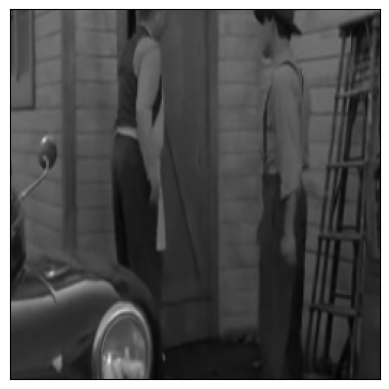

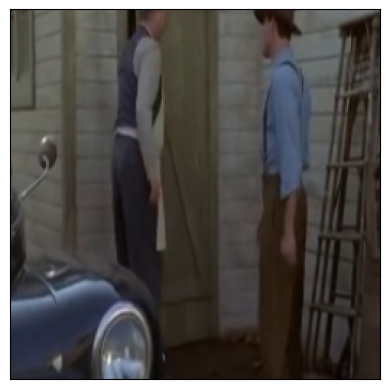

In [10]:
# # Test Dataset and dataloader
dataset = ColorizationDatasetMovies()
dataloader = DataLoader(dataset, 1, shuffle=True)

black, color = next(iter(dataloader))
show_tensor_images(black, num_images=1, size=(1, 256, 256))
show_tensor_images(color, num_images=1, size=(3, 256, 256))

In [11]:
# Params
LR = 0.0002
LAMBDA = 100
EPOCHS = 20
BATCH_SIZE = 32
WORKERS = 0
DISPLAY_IMAGES = 3
LOAD_MODEL = True
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# Model Creation
generator = Generator(img_c=1).to(DEVICE)
critic = Critic().to(DEVICE)

# Init weights
generator.apply(init_std)
critic.apply(init_std)

if LOAD_MODEL:
    generator.load_state_dict(torch.load('generator.pth'))
    critic.load_state_dict(torch.load('critic.pth'))

generator_optimizer = optim.Adam(generator.parameters(), LR, betas=(0.5, 0.999))
critic_optimizer = optim.Adam(critic.parameters(), LR, betas=(0.5, 0.999))

generator_scaler = torch.cuda.amp.GradScaler()
critic_scaler = torch.cuda.amp.GradScaler()

loss = nn.BCEWithLogitsLoss()

# Declare dataset
dataset = ColorizationDatasetMovies()
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True, num_workers=WORKERS, drop_last=True)

dataset_test = ColorizationDatasetMovies(train=False)
dataloader_test = DataLoader(dataset_test, DISPLAY_IMAGES, shuffle=True, num_workers=WORKERS, drop_last=True)

Starting training on epoch 0. 24256 examples will take 758 batches.
Epoch 0 took: 484.6897008419037 seconds.
Black / White


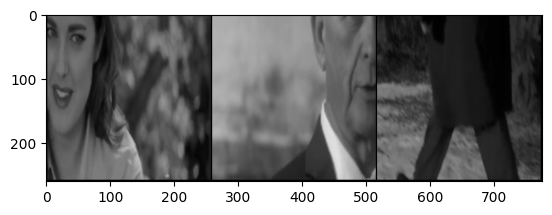

Original


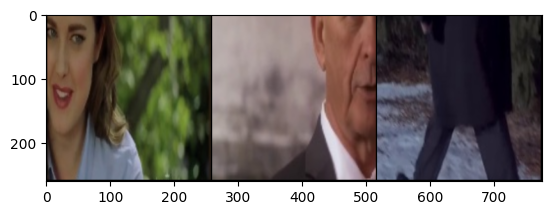

Colorized


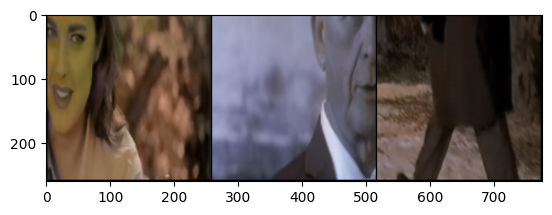

--------------------

Starting training on epoch 1. 24256 examples will take 758 batches.
Epoch 1 took: 480.08627700805664 seconds.
Black / White


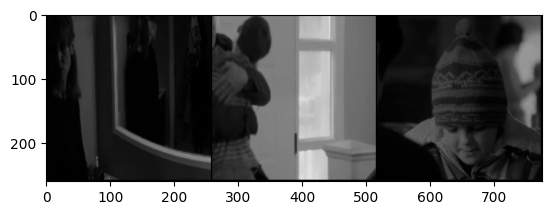

Original


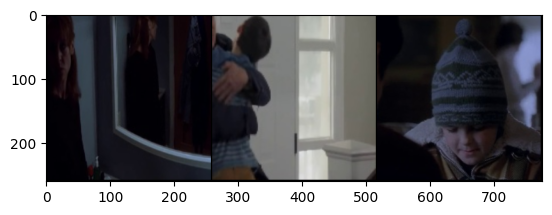

Colorized


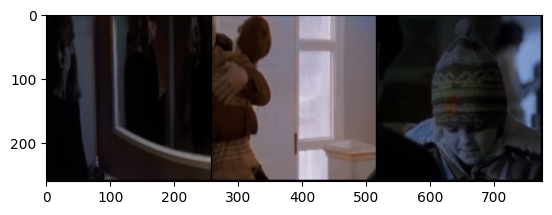

--------------------

Starting training on epoch 2. 24256 examples will take 758 batches.
Epoch 2 took: 477.55363631248474 seconds.
Black / White


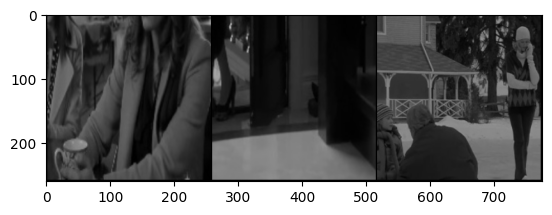

Original


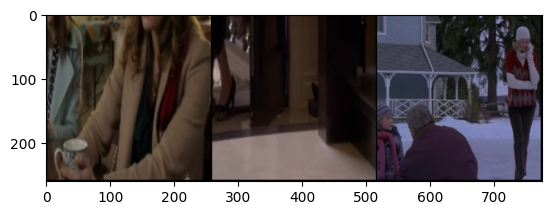

Colorized


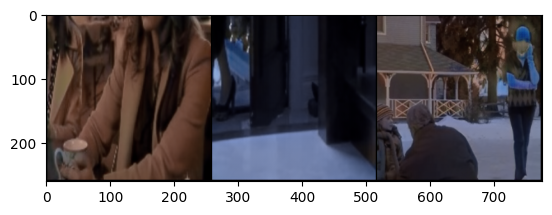

--------------------

Starting training on epoch 3. 24256 examples will take 758 batches.
Epoch 3 took: 479.1195602416992 seconds.
Black / White


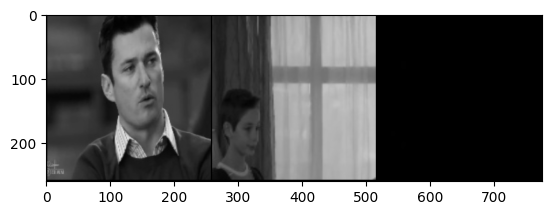

Original


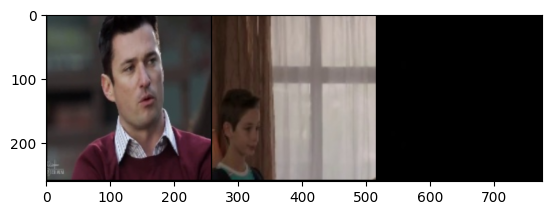

Colorized


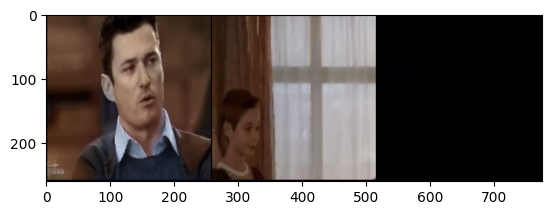

--------------------

Starting training on epoch 4. 24256 examples will take 758 batches.
Epoch 4 took: 478.737576007843 seconds.
Black / White


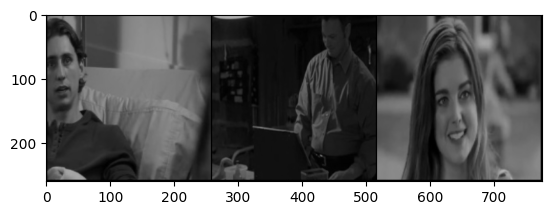

Original


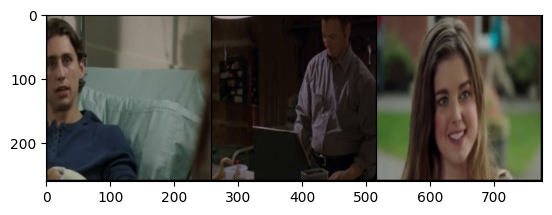

Colorized


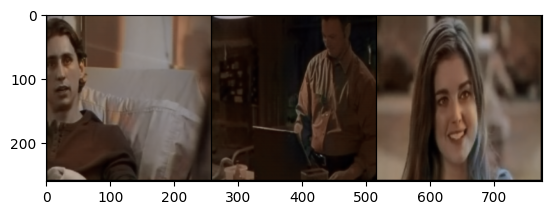

--------------------

Starting training on epoch 5. 24256 examples will take 758 batches.
Epoch 5 took: 478.54798913002014 seconds.
Black / White


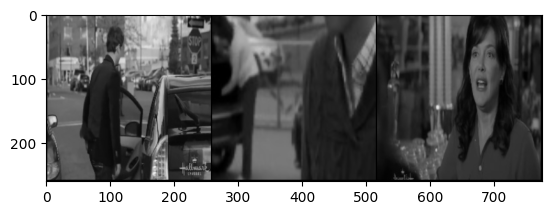

Original


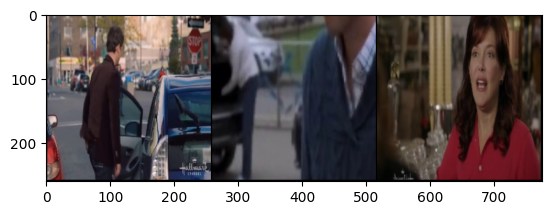

Colorized


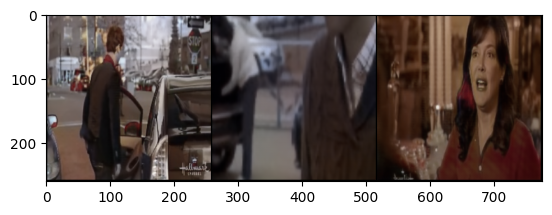

--------------------

Starting training on epoch 6. 24256 examples will take 758 batches.
Epoch 6 took: 476.55589723587036 seconds.
Black / White


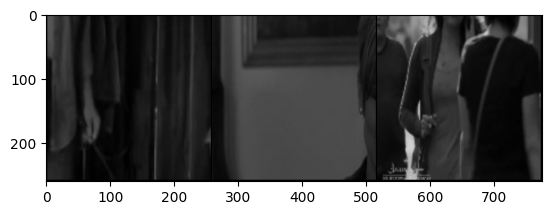

Original


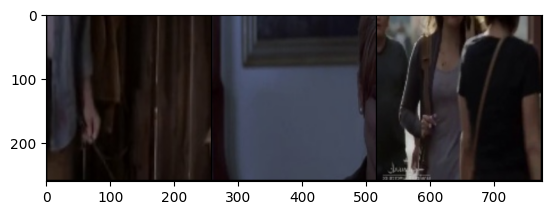

Colorized


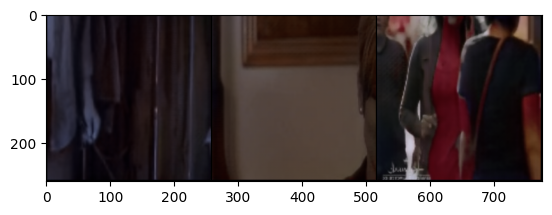

--------------------

Starting training on epoch 7. 24256 examples will take 758 batches.
Epoch 7 took: 476.76149249076843 seconds.
Black / White


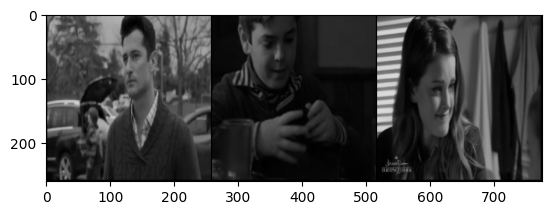

Original


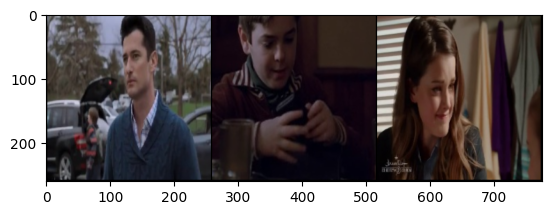

Colorized


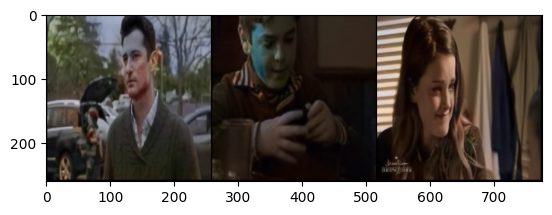

--------------------

Starting training on epoch 8. 24256 examples will take 758 batches.
Epoch 8 took: 476.47696924209595 seconds.
Black / White


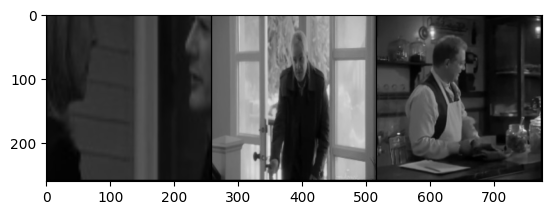

Original


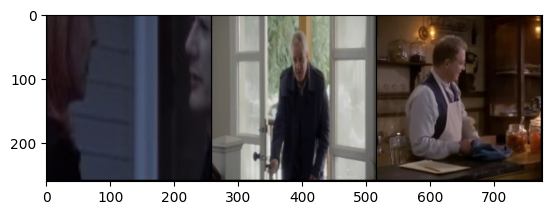

Colorized


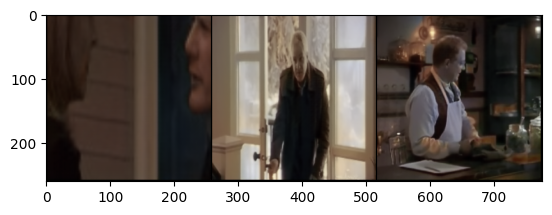

--------------------

Starting training on epoch 9. 24256 examples will take 758 batches.
Epoch 9 took: 476.92513155937195 seconds.
Black / White


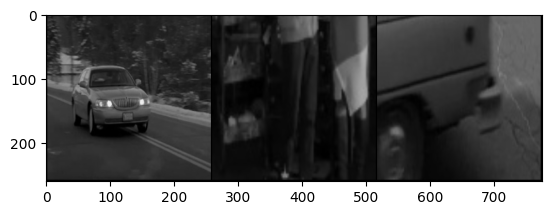

Original


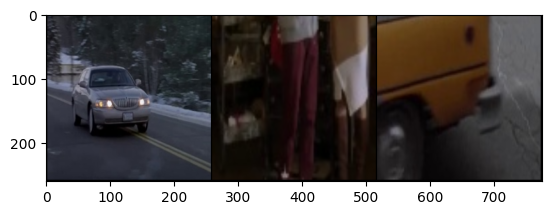

Colorized


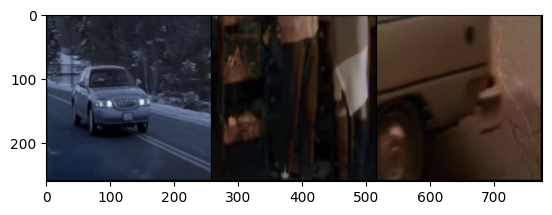

--------------------

Starting training on epoch 10. 24256 examples will take 758 batches.
Epoch 10 took: 476.82775259017944 seconds.
Black / White


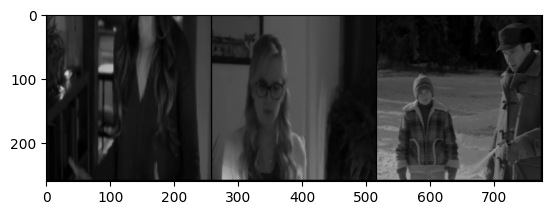

Original


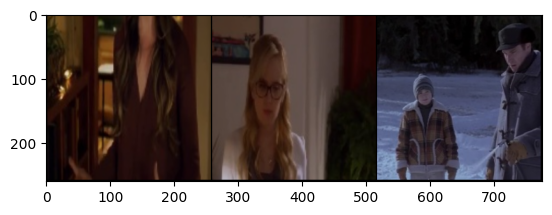

Colorized


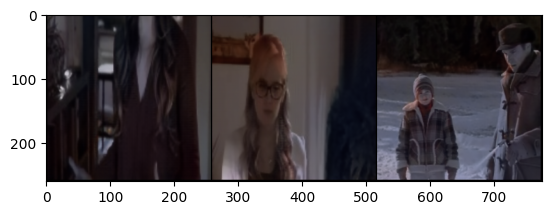

--------------------

Starting training on epoch 11. 24256 examples will take 758 batches.
Epoch 11 took: 476.38890266418457 seconds.
Black / White


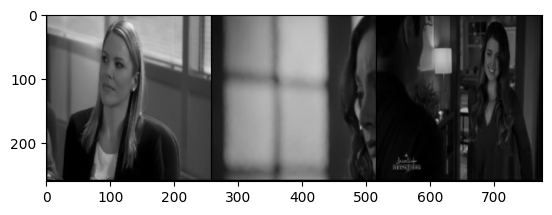

Original


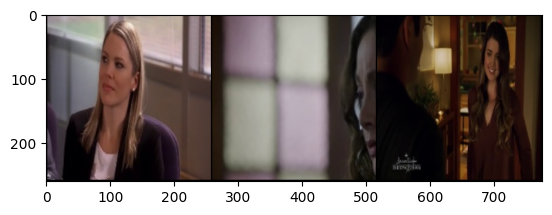

Colorized


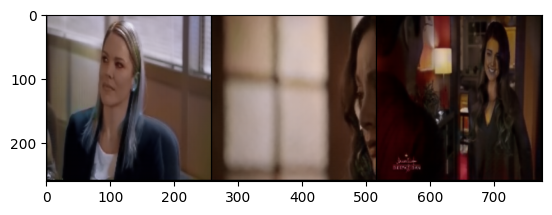

--------------------

Starting training on epoch 12. 24256 examples will take 758 batches.
Epoch 12 took: 477.33701276779175 seconds.
Black / White


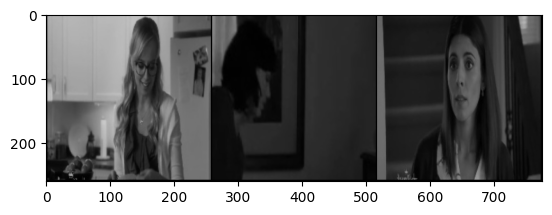

Original


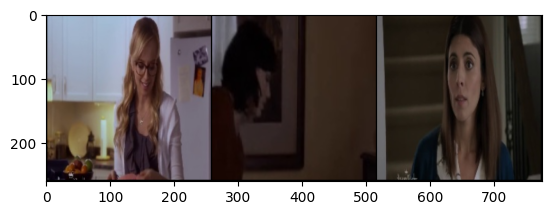

Colorized


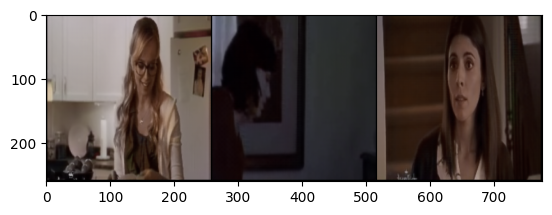

--------------------

Starting training on epoch 13. 24256 examples will take 758 batches.
Epoch 13 took: 478.20820021629333 seconds.
Black / White


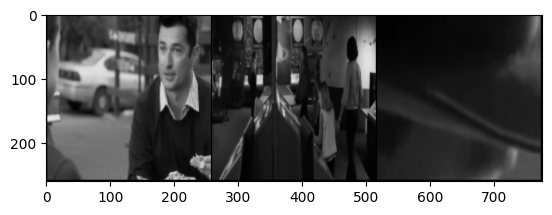

Original


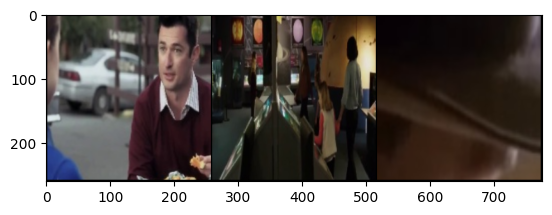

Colorized


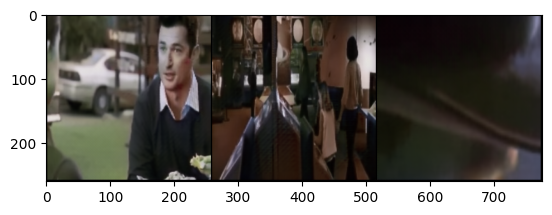

--------------------

Starting training on epoch 14. 24256 examples will take 758 batches.
Epoch 14 took: 476.7352707386017 seconds.
Black / White


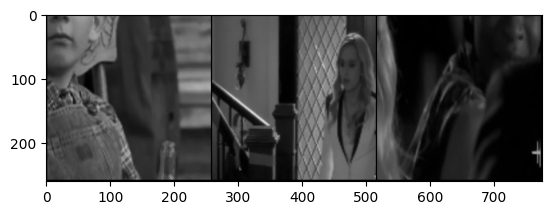

Original


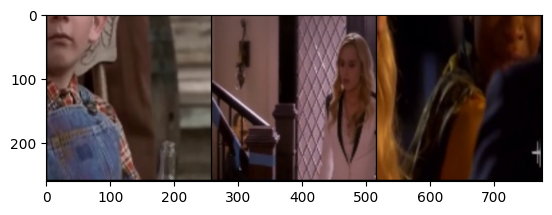

Colorized


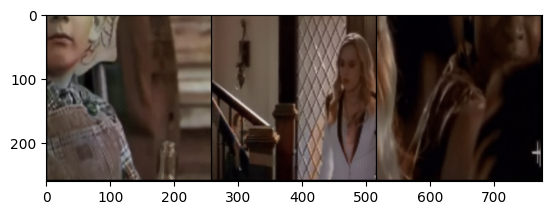

--------------------

Starting training on epoch 15. 24256 examples will take 758 batches.
Epoch 15 took: 477.486186504364 seconds.
Black / White


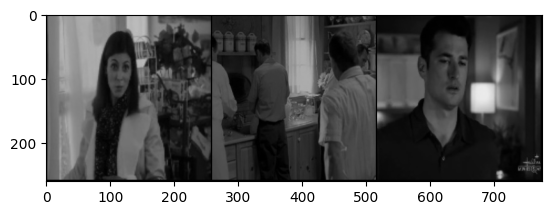

Original


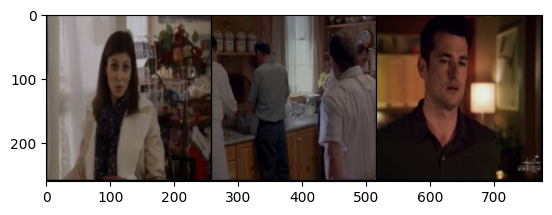

Colorized


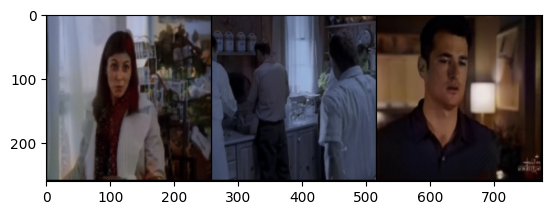

--------------------

Starting training on epoch 16. 24256 examples will take 758 batches.
Epoch 16 took: 476.8076765537262 seconds.
Black / White


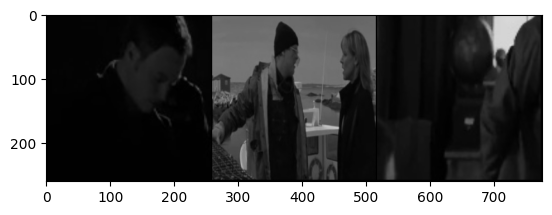

Original


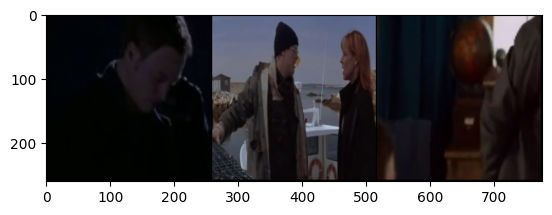

Colorized


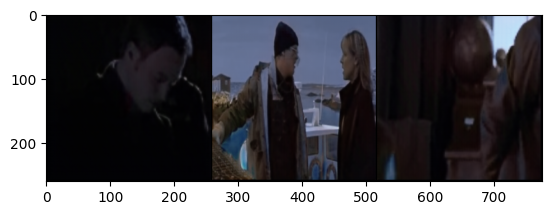

--------------------

Starting training on epoch 17. 24256 examples will take 758 batches.
Epoch 17 took: 476.94879508018494 seconds.
Black / White


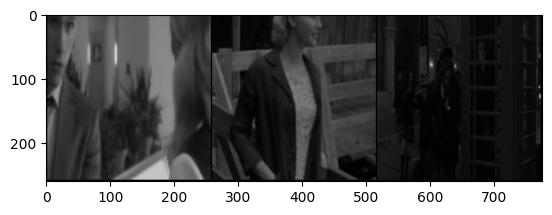

Original


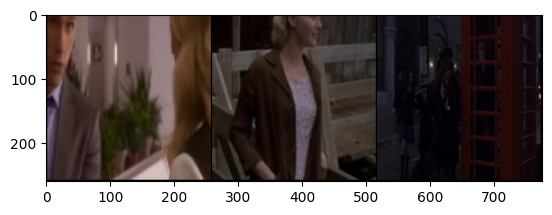

Colorized


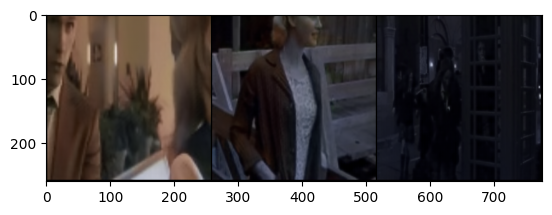

--------------------

Starting training on epoch 18. 24256 examples will take 758 batches.
Epoch 18 took: 476.10575103759766 seconds.
Black / White


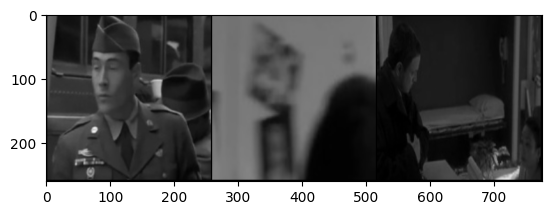

Original


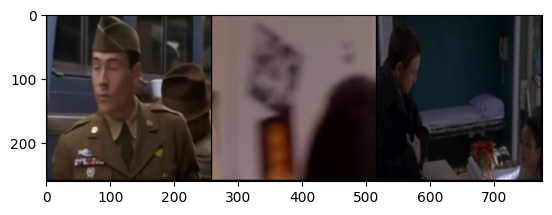

Colorized


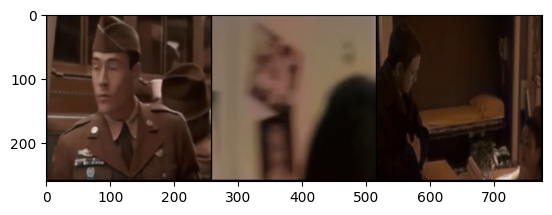

--------------------

Starting training on epoch 19. 24256 examples will take 758 batches.
Epoch 19 took: 476.26311564445496 seconds.
Black / White


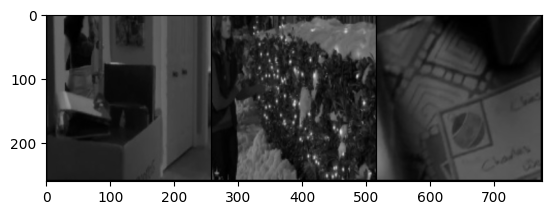

Original


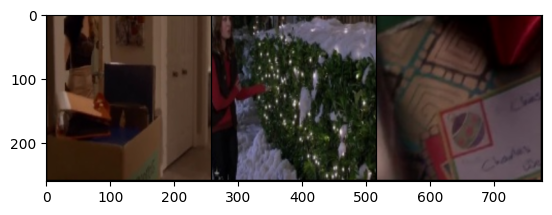

Colorized


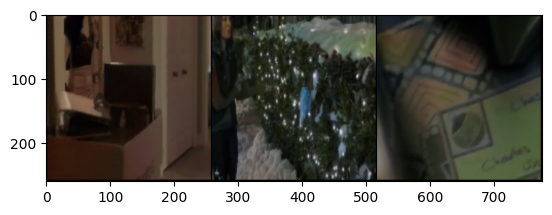

--------------------



In [13]:
for epoch in range(EPOCHS):
    print(f'Starting training on epoch {epoch}. {len(dataset)} examples will take {len(dataset) // BATCH_SIZE} batches.')
    start_time = time()
    
    for _, (black, color) in enumerate(dataloader):
        black = black.to(DEVICE)
        color = color.to(DEVICE)
        
        with torch.cuda.amp.autocast():
            fake_color = generator(black)
            
            scores_real = critic(color)
            scores_fake = critic(fake_color.detach())
            
            loss_real = loss(scores_real, torch.ones_like(scores_real))
            loss_fake = loss(scores_fake, torch.zeros_like(scores_fake))
            
            critic_loss = (loss_real + loss_fake) / 2
            
        critic.zero_grad()
        critic_scaler.scale(critic_loss).backward()
        critic_scaler.step(critic_optimizer)
        critic_scaler.update()
        
        with torch.cuda.amp.autocast():
            scores = critic(fake_color)
            generator_loss = loss(scores, torch.ones_like(scores)) + LAMBDA * nn.L1Loss()(color, fake_color)
            
        generator_optimizer.zero_grad()
        generator_scaler.scale(generator_loss).backward()
        generator_scaler.step(generator_optimizer)
        generator_scaler.update()
        
    # Display generated images after each epoch and print time of epoch
    print(f'Epoch {epoch} took: {time() - start_time} seconds.')
    black, color = next(iter(dataloader_test))
    
    print('Black / White')
    show_tensor_images(black, num_images=DISPLAY_IMAGES, size=(1, 256, 256))
    print('Original')
    show_tensor_images(color, num_images=DISPLAY_IMAGES, size=(3, 256, 256))

    generator.eval()
    with torch.no_grad():
        fake_color = generator(black.to(DEVICE)).detach()
        print('Colorized')
        show_tensor_images(fake_color.to(torch.float32), num_images=DISPLAY_IMAGES, size=(3, 256, 256))
        generator.train()
    
    torch.save(generator.state_dict(), 'generator.pth')
    torch.save(critic.state_dict(), 'critic.pth')
    print(f'{"-" * 20}\n')
        

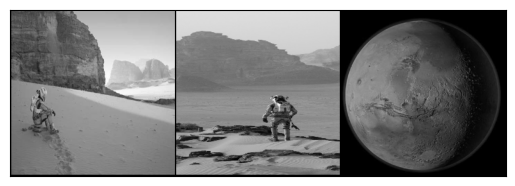

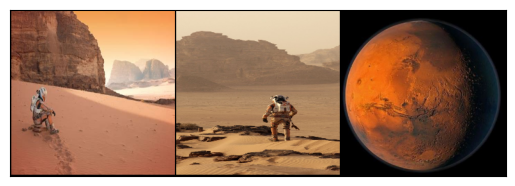

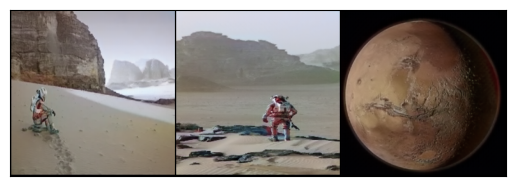

In [14]:
# Colorize images from the Martian movie
def getImage(path, mode):
    image = read_image(path, mode=ImageReadMode.GRAY if mode == 'GRAY' else ImageReadMode.RGB) / 255
    image = image[None, :, :, :]
    image = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR)(image)
    image = image * 2 - 1 # Scale between -1 to 1
    return image

black_images = torch.cat(
    (
        getImage('data/test/0.jpeg', 'GRAY'),
        getImage('data/test/1.jpeg', 'GRAY'),
        getImage('data/test/2.jpeg', 'GRAY')
    )
    ,0)
colored_images = torch.cat(
    (
        getImage('data/test/0.jpeg', 'RGB'),
        getImage('data/test/1.jpeg', 'RGB'),
        getImage('data/test/2.jpeg', 'RGB')
    )
    ,0)

generator.eval()
with torch.no_grad():
    colorized = generator(black_images.to(DEVICE)).detach()
    show_tensor_images(black_images, num_images=DISPLAY_IMAGES, size=(1, 256, 256))
    show_tensor_images(colored_images, num_images=DISPLAY_IMAGES, size=(3, 256, 256))
    show_tensor_images(colorized.to(torch.float32), num_images=DISPLAY_IMAGES, size=(3, 256, 256))
    
    generator.train()